# Spatial autocorrelation and GWR

In this notebook I will explore the existence of spatial autocorrelation in the ASC dataset and fit a **Geographically Weighted Regression** model (GWR) to predict, once again, the number of pickups.


In [2]:
import numpy as np, pandas as pd, seaborn as sns
from matplotlib import pyplot as plt
import geopandas as gpd

%matplotlib inline

In [3]:
# Polygons of blocks in New York.
nymap = gpd.read_file("./taxi/nyc_cbg_geoms.geojson")
nymap["geoid"] = nymap["geoid"].astype(np.int64)

#socioeconomic data
acs = pd.read_csv("./taxi/nyc_acs_demographics.csv", dtype = {"geoid" : np.int64}, index_col=0)
block_acs = acs.pivot(index = "geoid", columns = "acs_demog_var" ).droplevel(level = 0, axis = 1)

#number of pickups per block
pickup_counts = pd.read_csv("./files/pickups_per_day_per_block.csv", index_col = 0)

## Inputting missing data from neighbor blocks: spatial self join

Like the last time, we input the missing values using the neighbor blocks, which will **more likely be similar** to the current missing one.

We perform a **spatial self join** to find the neigbors, which is more efficient than computing the intersection of each pair of blocks. Since colindant blocks apparently do intersect upscaling the polygons is no longer needed.

In [4]:
intersections = gpd.sjoin(nymap, nymap, how = "inner", op = "intersects")
neighbors = intersections.groupby("geoid_left")["geoid_right"].apply(list)
neighbors = gpd.GeoDataFrame(neighbors)
_ = neighbors.apply(lambda x: x["geoid_right"].remove(x.name), axis=1)
neighbors["number_neighbors"] = neighbors.apply(lambda x: len(x[0]),axis = 1)

In [5]:
def input_from_neighbors(df, columns_to_input, neighbors_df):
    data = df.copy()
    for column_name in columns_to_input:
        #We find which rows are misisng values 
        rows_missing_values = data[data[column_name].isna()].index
        for geoid in rows_missing_values:
            neighbors = neighbors_df.loc[geoid]["geoid_right"] #we search for neighbors of geoid
            median_value_neighbors = data[column_name].loc[neighbors].median() #we compute here the median of neighbors
            data.loc[geoid][column_name] = median_value_neighbors
    return data

In [6]:
# Drops features and checks that no longer are there missing values
block_acs.drop(["aggregate_travel_time_to_work", "owner_occupied_housing_units_median_value"], axis = 1, inplace = True)

columns_to_input = ["income_per_capita","median_age", "median_income","median_rent", "median_year_structure_built", "renter_occupied_housing_units_paying_cash_median_gross_rent"]
count = 0
while(block_acs.isna().sum().sum() > 0 and count < 5):
    block_acs = input_from_neighbors(block_acs, columns_to_input , neighbors)
    count +=1

#There are some blocks (4) which do not have neighbors (islands). We input the median of all blocks for their missing values
median_values = block_acs.median(axis = 0).to_dict()
block_acs = block_acs.fillna(value = median_values)
print(block_acs.isna().sum().sum())

/Users/juanluisrto/opt/anaconda3/envs/carto/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0


We define a **geodataframe** joining the polygons and the number of pickups together with the block ACS data

In [7]:
pickups_per_day_per_block = pd.read_csv("./files/pickups_per_day_per_block.csv", index_col=0)
pickup_counts = pickups_per_day_per_block["total"]

#model_data = pd.merge(block_acs,pickup_counts, right_index = True, left_index = True, how = "inner" )

In [275]:
# merge ACS and pickups
df = pd.merge(block_acs,pickup_counts, right_index = True, left_index = True, how = "left" )
# merge result with nymap polygons
df = pd.merge(df,nymap, left_index = True, right_on = "geoid")
df.rename(columns = {"total" : "pickups", "renter_occupied_housing_units_paying_cash_median_gross_rent" : "renter_cash_payers"}, inplace = True)
gdf = gpd.GeoDataFrame(df, geometry = "geometry")
gdf.pickups.fillna(0, inplace = True) # We set 0 pickups for the blocks which dont have data

<AxesSubplot:title={'center':'Number of pickups per block'}>

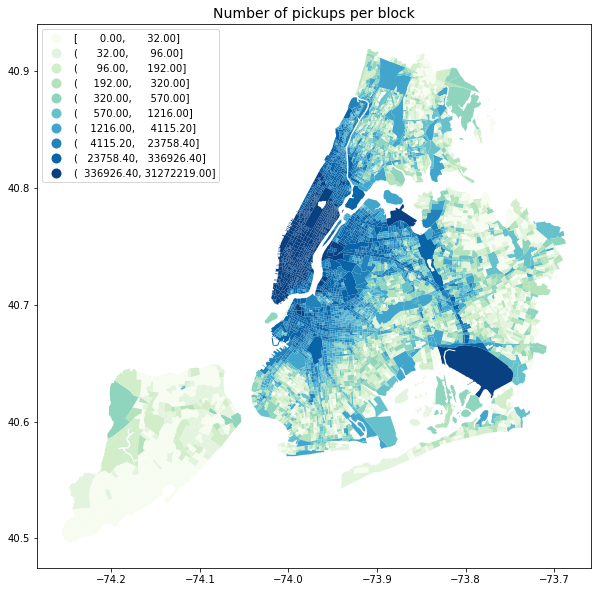

In [9]:
fig, ax = plt.subplots(figsize=(10,10), subplot_kw={'aspect':'equal'})
ax.set_title("Number of pickups per block", fontdict={"fontsize" : 14})
gdf.plot(column='pickups', scheme='Quantiles', k=10, cmap='GnBu', legend=True, ax=ax, legend_kwds ={"loc": "upper left" })

## Spatial autocorrelation
By looking at the chart above we immediately perceive the pattern of an increasing number of pickups the closer we are to Manhattan. I will try to exploit this information and build a model which takes advantage of this spatial autocorrelation.

I note down here the most insightful concepts i have learned about spatial autocorrelation these past days.

**Spatial autocorrelation** comprises two types of similarity in data, namely:
- *spatial similarity* (the fact that two observations are geographically close to each other)
- *attribute similarity* (how the features between such observations actually relate to each other)

For example, blocks in Manhattan share both similarities, since they are close to each other and have a high number of pickups. Instead, JF Kennedy Airport does not share attribute similarity to its surrounding block even though there is spatial similarity. On the other hand, JKF does share attributes with La Guardia airport(no population, enormous amount of pickups) but there is no spatial similarity (they are far away from each other)

To account for *spatial similarity* we introduce the notion of neighbors of an observation, which are points/areas lying within a given distance from it. We assign weights to them depending on how far they are. In this study we will use **Queens distance**, which takes as neighbors the areas that share an edge or a corner with the area in which our observation is defined. 

To account for *attribute similarity*, we use **Spatial Lag** defined as:$ ylag_i = \sum_j w_{i,j} y_j$. For an observation $i$ it takes the weighted sum of the values in all its neighbors. We weight each neighbor with the distance defined above.


### Measurement of Spatial Autocorrelation: Moran's Index
> $$ I = \frac N W \frac {\sum_i \sum_j w_{ij}(x_i-\bar x) (x_j-\bar x)} {\sum_i (x_i-\bar x)^2}  $$

where  $N$ is the number of spatial units indexed by  $i$ and  $j$;  $x$ is the variable of interest;  $x$ is the mean of  $x$;  $w_{ij}$ is a matrix of spatial weights with zeroes on the diagonal (i.e.,  $w_{ii} = 0$); and  $W$ is the sum of all  $w_{ij}$. (credits to Wikipedia)

I see Moran's Index as the equivalent of Pearson correlation but for multiple dimensions and directions (a single feature can be correlated with itself in various ways, depending on a direction we are looking). We are introducing directionality in the measurement.


I have also learned that Moran's Index can be computed in the form of **Global Autocorrelation** (taking the dataset as a whole) and **Local Autocorrelation** (finding clusters which behave distinctly and looking for autocorrelation there)


In [202]:
import libpysal as lps
import esda

We start by computing the weights for the observations using **Queens distance** and the **Spatial Lag** of each observation

In [276]:
gdf.set_index("geoid", inplace = True)
gdf_copy = gdf.copy()
target = gdf['pickups']
queen_weights =  lps.weights.Queen.from_dataframe(gdf) #another (faster?) way to compute the neighbors for each block
queen_weights.transform = 'r'
lag_pickups = lps.weights.lag_spatial(queen_weights, target) # returns the spatial lag for the pickups of each block´s neighbors

('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1130, ' is an island (no neighbors)')
('WARNING: ', 3223, ' is an island (no neighbors)')
('WARNING: ', 4165, ' is an island (no neighbors)')


/Users/juanluisrto/opt/anaconda3/envs/carto/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 9 disconnected components.
 There are 4 islands with ids: 0, 1130, 3223, 4165.
  warnings.warn(message)


As we can see above there are blocks which are isolated (islands) and dont have neighbors. Weights cannot be computed for those. In fact, we will discard them since they are outliers.

In [204]:
def remove_islands(gdf, target, queen_weights):
    islands = gdf.iloc[queen_weights.islands]
    non_islands = gdf.drop(islands.index)
    non_island_target = target[non_islands.index]
    non_island_weights = lps.weights.Queen.from_dataframe(non_islands) #recompute weights
    return non_islands, non_island_target,non_island_weights

## Global Moran's Index
We start by computing Morans index for the dataset at a global level. We get a 53% with a sufficiently low p-value which lets us reject the null hypothesis (which says that this level of spatial autocorrelation is due to randomness in a 1:100 ratio)

In [277]:
gdf, target, queen_weights =  remove_islands(gdf, target, queen_weights)

/Users/juanluisrto/opt/anaconda3/envs/carto/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
  warnings.warn(message)


In [214]:
mi = esda.moran.Moran(target, queen_weights)
print("Global Moran's index: ",mi.I)
print("p-value ",mi.p_sim)

Global Moran's index:  0.5340342894743313
p-value  0.001


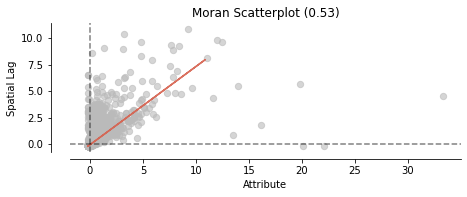

In [218]:
from splot.esda import moran_scatterplot
fig, ax = moran_scatterplot(mi, zstandard = True, aspect_equal=True)

This scatterplot comparing pickups with the pickup spatial lag showcases that positive autocorrelation is present indeed. However, by applying again log transformations to independent and dependent variables, as I did in the previous modelling, we get even better results.

In [588]:
from TaxiBlockCount import data_transformation
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [524]:
log_tr = list(gdf.columns.values)
log_tr.remove("geometry")
#log_tr.remove("pickups")
X, y, scl = data_transformation(gdf, remove_outliers = False, target = "pickups", log_transform=log_tr)
X["pickups"] = y
log_queen_weights = lps.weights.Queen.from_dataframe(X) 

/Users/juanluisrto/opt/anaconda3/envs/carto/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
  warnings.warn(message)


In [220]:
log_mi = esda.moran.Moran(y, log_queen_weights)
print("Global Moran's index: ",log_mi.I)
print("p-value ",log_mi.p_sim)

Global Moran's index:  0.8688646163693214
p-value  0.001


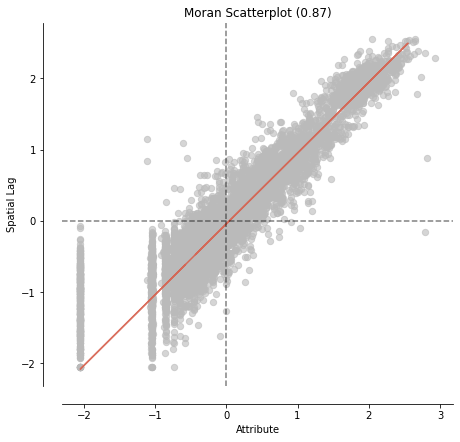

In [221]:
fig, ax = moran_scatterplot(log_mi, zstandard = True, aspect_equal=True)

## Local Moran's Index
With local moran we get an array of local indices for each individual observation. Each of them has an assigned p-value. We will use this p-value to **discard as outliers** the observations which are s**ignificantly non spatially autocorrelated**. This means that their neighbors cannot be used to predict properly the target variable. Im thinking in particular in both of the airports.

We can find these values in the top-left and bottom-right quadrants of the moran scatterplot below


/Users/juanluisrto/opt/anaconda3/envs/carto/lib/python3.8/site-packages/splot/_viz_esda_mpl.py:47: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
/Users/juanluisrto/opt/anaconda3/envs/carto/lib/python3.8/site-packages/splot/_viz_esda_mpl.py:48: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


(<Figure size 1080x504 with 2 Axes>, <AxesSubplot:>)

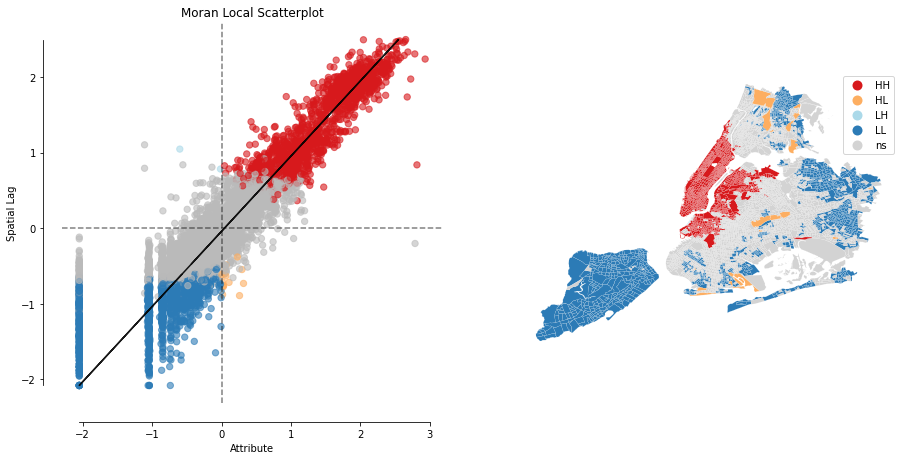

In [242]:
from splot.esda import moran_scatterplot, lisa_cluster

fig, ax = plt.subplots(1,2, figsize = (15,7))
li = esda.moran.Moran_Local(y, log_queen_weights)
moran_scatterplot(li, p=0.05,  aspect_equal=False, ax = ax[0])
lisa_cluster(li, gdf, ax = ax[1])

We can distinguish the specific type of local spatial association reflected in the four quadrants of the Moran Scatterplot above:

* `Hotspots`: High-High (upper right)
* `Coldspots`: Low-Low (bottom left)
* `Doughnuts`: High-Low (lower right) Places were target is low and neighbors are high (parks, lakes?)
* `Diamonds`: Low-High (upper left) Places were target is high and neighbors are low (airports)

In the map we can effectively appreciate how there is positive spatial autocorrelation close to Manhattan and in the big island (low values)

In [262]:
sig = li.p_sim < 0.05
hotspot = sig * li.q==1
coldspot = sig * li.q==3
doughnut = sig * li.q==2
diamond = sig * li.q==4

In [ ]:
outliers = doughnut + diamond
gdf["outliers"] = outliers

<AxesSubplot:title={'center':'Outliers'}>

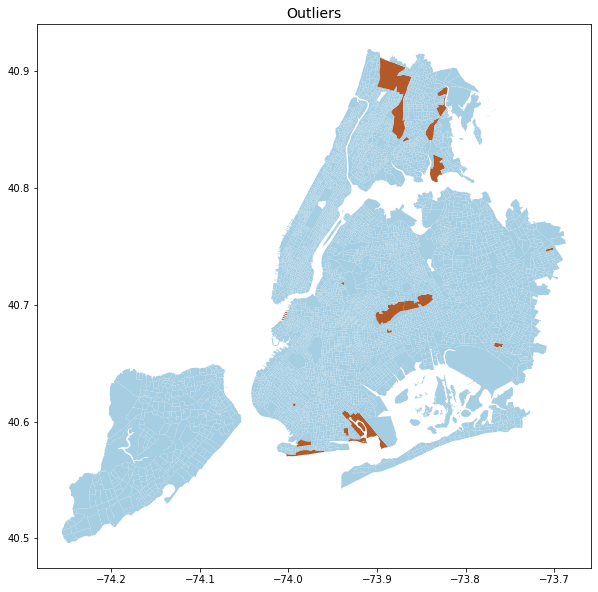

In [264]:
fig, ax = plt.subplots(figsize=(10,10), subplot_kw={'aspect':'equal'})
ax.set_title("Outliers", fontdict={"fontsize" : 14})
gdf.plot(column='outliers', cmap='Paired', ax=ax)

Above we can see the blocks where spatial autocorrelation is not present with a probability of 95% or more. Unfortunately the airports are not there, so we will have to keep them.

## Geographically weighted regression

In [101]:
from pysal.model.mgwr.gwr import GWR, MGWR
from pysal.model.mgwr.sel_bw import Sel_BW 
from sklearn.model_selection import train_test_split

In [527]:
geoseries = gpd.GeoSeries(X.geometry, crs = 4326)
coords = [(x.coords.xy[0][0],x.coords.xy[1][0]) for x in geoseries[~outliers].centroid.values]
X.drop(['geometry','pickups'], axis = 1, inplace = True)

<ipython-input-527-6139ad967412>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  coords = [(x.coords.xy[0][0],x.coords.xy[1][0]) for x in geoseries[~outliers].centroid.values]


### Linearly dependent variables
We have a pair of linearly dependent variables since the rank of our X matrix is 29 and we have 30 variables. We need to find and remove one of the dependent variables in order to run GWR. We test the **Cauchy-Schwarz inequality** between each pair of columns to see if their inner product equals the product of the norms.
$$ |\langle \mathbf{u},\mathbf{v}\rangle| ^2 \leq \langle \mathbf{u},\mathbf{u}\rangle \cdot \langle \mathbf{v},\mathbf{v}\rangle $$ 

We find that `households` and `occupied_housing_units` are linearly dependant and remove one of them. 

In [529]:
#Cauchy-Schwarz inequality
#https://stackoverflow.com/questions/28816627/how-to-find-linearly-independent-rows-from-a-matrix
def linear_dependence(df):
    matrix = df.values
    for i in range(matrix.shape[1]):
        for j in range(matrix.shape[1]):
            if i != j:
                inner_product = np.inner(
                    matrix[:,i],
                    matrix[:,j]
                )
                norm_i = np.linalg.norm(matrix[:,i])
                norm_j = np.linalg.norm(matrix[:,j])

                if np.abs(inner_product - norm_j * norm_i) < 1E-5:
                    print('Dependent: ',i,j, df.columns[i], df.columns[j])
linear_dependence(X[:50])

Dependent:  10 21 households occupied_housing_units
Dependent:  21 10 occupied_housing_units households


In [530]:
# We remove the outliers and occupied_housing_units  

X = X[~outliers]
y = y[~outliers]
X["coords"] = coords
X.drop(['occupied_housing_units'], axis = 1, inplace = True)

#We use the quadrant (li.q) to perform stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, stratify = li.q[~outliers])
coords_train = list(X_train.pop("coords").values)
coords_test = list(X_test.pop("coords").values)

<ipython-input-530-fb27931588b2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["coords"] = coords
/Users/juanluisrto/opt/anaconda3/envs/carto/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


### Bandwidth Selection
I use `Sel_BW` to calculate the optimal number of neighbors to take into account for the regression.

In [508]:
gwr_selector = Sel_BW(coords_train,  y_train.values.reshape(-1,1), X_train.values)
gwr_bw = gwr_selector.search(bw_min=2)
print(gwr_bw)

519.0


### GWR modelling
I build a simple GWR assuming a **Gaussian distribution** underlying the data and the default bisquare kernel.
I tried to set `family = f.Poisson()` since the Poisson distribution expresses the probability of a given number of events occurring in a fixed interval of time. This is our case, since we are predicting the number of pickups in each block during 3 months in total. It is true though that after the logarithmic transformations the Poisson distribution might have been altered. Anyways, I could not fit the model due to continuous errors with GWR so I finally stuck with the gaussian.  

In [533]:
import pysal.model.spglm.family as f
model = GWR(coords_train,  y_train.values.reshape(-1,1), X_train.values, bw = gwr_bw)
gwr_results = model.fit()

In [534]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                5053
Number of covariates:                                                    31

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           2190.912
Log-likelihood:                                                   -5058.591
AIC:                                                              10179.182
AICc:                                                             10181.603
BIC:                                                             -40635.385
R2:                                                                   0.571
Adj. R2:                                                              0.568

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

### Model evaluation
- In the summary we can see how the GWR reaches **0.872** for $R^2$ in comparison with the standard regression model which only obtains a score of **0.571**.
- The RSS error is minimized better by GWR. GWR = **654.687** and OLS = **2190.912**
- In the test set we get a $R^2$ of **0.90** and a RSS of **226.46**

In [536]:
scale = gwr_results.scale
residuals = gwr_results.resid_response

In [540]:
pred_results = model.predict(coords_test, X_test.values, scale, residuals)

In [544]:
R_2 = np.corrcoef(pred_results.predictions.flatten(), y_test.values.flatten())[0][1]
print("R^2:", R_2)

R^2: 0.9035147416690762


In [563]:
RSS = np.sum((pred_results.predictions.flatten()- y_test.values.flatten())**2)
print("RSS:", RSS)

RSS: 226.46503339824727


## Predict and export all blocks

In [570]:
_ = X.pop("coords")
predict_train = model.predict(coords_train,X_train.values, scale, residuals)

In [576]:
X_train["predictions"] = predict_train.predictions
X_test["predictions"] =  pred_results.predictions
X_predicted = pd.concat([X_train,X_test])

In [589]:
from TaxiBlockCount import reverse_transformation
# We need to insert the removed column in order to rollback the transformation
X_predicted.insert(21, "occupied_housing_units",gdf.occupied_housing_units)
predicted_pickups = reverse_transformation(X_predicted, scl)
pred_pickups_df = predicted_pickups.rename(columns = {"predictions": "pred_pickups"})["pred_pickups"]
pred_pickups_df.to_csv("./files/pred_pickups_gwr.csv")